In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertModel, BertTokenizerFast
import torch
from sklearn.decomposition import PCA

/opt/anaconda3/envs/stat234/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Figuring out semantic embeddings

In [1]:
#these are the embeddings per task in mt10!
all_env_mt10=['reach-v2', 'push-v2','pick-place-v2', 'door-open-v2', 'drawer-open-v2','drawer-close-v2','button-press-topdown-v2','peg-insert-side-v2','window-open-v2','window-close-v2']
chat_phrase_mt10={'reach-v2':'Reach target with robotic arm', 'push-v2': 'Push object to target position', 'pick-place-v2':'Pick and place object precisely', 'door-open-v2':'Open door by rotating handle','drawer-open-v2':'Open drawer by pulling outward','drawer-close-v2':'Close drawer by pushing backward', 'button-press-topdown-v2':'Press button top-down until depressed','peg-insert-side-v2':' Insert peg side into slot', 'window-open-v2':'Open window by sliding panel','window-close-v2':'Close window by sliding panel'}
for key in chat_phrase_mt10:
    print(key in all_env_mt10)

True
True
True
True
True
True
True
True
True
True


In [7]:
texts=[]
for key in chat_phrase_mt10:
    texts.append(chat_phrase_mt10[key])

In [8]:
print(texts)

['Reach target with robotic arm', 'Push object to target position', 'Pick and place object precisely', 'Open door by rotating handle', 'Open drawer by pulling outward', 'Close drawer by pushing backward', 'Press button top-down until depressed', ' Insert peg side into slot', 'Open window by sliding panel', 'Close window by sliding panel']


In [42]:
#using bert to interpret phrases!

model_name="bert-base-uncased"
tokenizer=BertTokenizerFast.from_pretrained(model_name)
model=BertModel.from_pretrained(model_name)
model.eval() 


enc=tokenizer(
    texts,
    padding=True,
    truncation=True,
    return_tensors="pt"
)

with torch.no_grad():
    outputs=model(**enc)


cls_embeddings=outputs.pooler_output

cls_embeddings_alt=outputs.last_hidden_state[:, 0, :]


attention_mask=enc["attention_mask"].unsqueeze(-1)
masked_hiddens=outputs.last_hidden_state * attention_mask
sum_hiddens=masked_hiddens.sum(dim=1)     
len_tokens=attention_mask.sum(dim=1)   
mean_embeddings=sum_hiddens/ len_tokens

print("CLS embeddings shape:", cls_embeddings.shape)
print("Mean embeddings shape:", mean_embeddings.shape)

CLS embeddings shape: torch.Size([10, 768])
Mean embeddings shape: torch.Size([10, 768])


In [13]:
#task ids print
for i in range(len(all_env_mt10)):
    print(f'({i},{all_env_mt10[i]})')

(0,reach-v2)
(1,push-v2)
(2,pick-place-v2)
(3,door-open-v2)
(4,drawer-open-v2)
(5,drawer-close-v2)
(6,button-press-topdown-v2)
(7,peg-insert-side-v2)
(8,window-open-v2)
(9,window-close-v2)


In [ ]:
pca = PCA(n_components=10)
low_dim = pca.fit_transform(vectors)

print(pca.explained_variance_ratio_.sum())
print(low_dim.shape)


In [57]:
def plotCosSimilarity(vectors,title):
    vectors=np.array(vectors)
    sim_matrix = cosine_similarity(vectors)

    plt.figure(figsize=(6, 5))
    plt.imshow(sim_matrix, interpolation='nearest', aspect='auto',cmap='Blues_r')
    plt.colorbar(label='Cosine similarity')
    plt.title(title,fontsize=15)
    plt.xlabel('Task index', fontsize=12.5)
    plt.ylabel('Task index',fontsize=12.5)
    plt.tight_layout()
    plt.show()


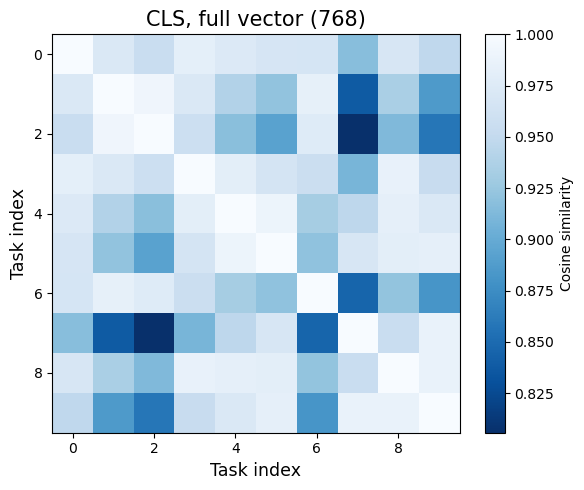

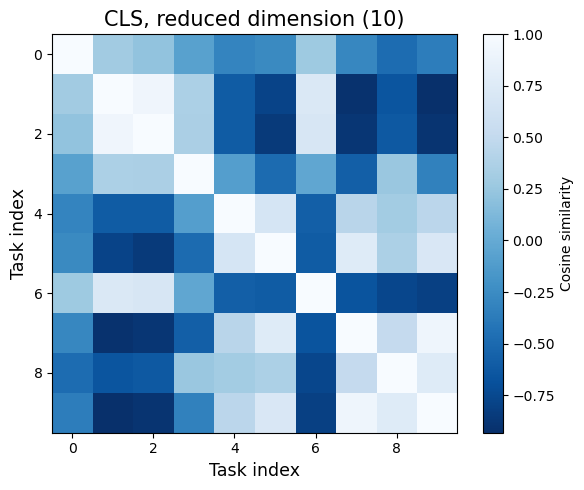

In [63]:
plotCosSimilarity(np.array(cls_embeddings),'CLS, full vector (768)')
pca = PCA(n_components=10)
low_dim = pca.fit_transform(cls_embeddings)
plotCosSimilarity(np.array(low_dim),'CLS, reduced dimension (10)')

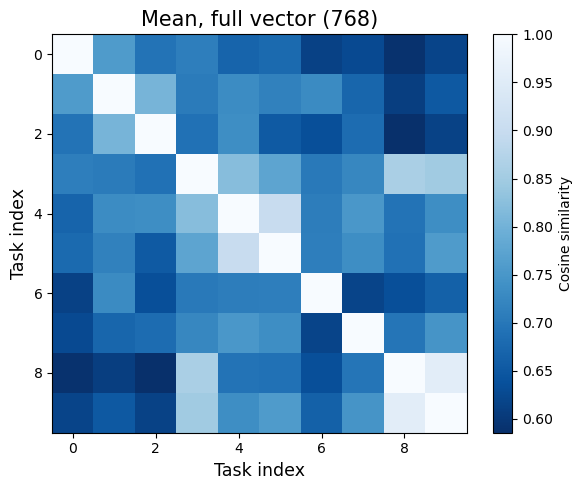

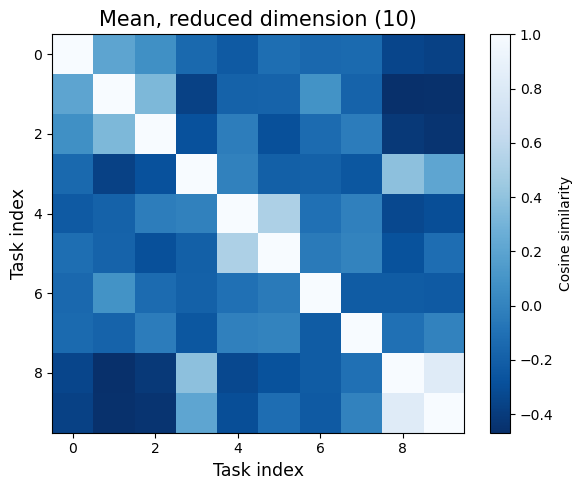

In [100]:
plotCosSimilarity(np.array(mean_embeddings),'Mean, full vector (768)')
pca = PCA(n_components=10)
low_dim = pca.fit_transform(mean_embeddings)
plotCosSimilarity(np.array(low_dim),'Mean, reduced dimension (10)')

In [110]:
a=np.array([1,0,0])
b=np.array([[1,2,3],[4,5,6],[7,8,9]])

one_hot_mod=np.einsum('ik,kj->ij', np.array([a]),b)
print(one_hot_mod)
print(one_hot_mod[0])
np.array([1,0,0])@np.array([[1,2,3],[4,5,6],[7,8,9]])

[[1 2 3]]
[1 2 3]


array([1, 2, 3])

# Plots for learning rate

In [73]:
#chatgpt function for file imports

import csv
def csv_to_numpy(filename, col_indices=(1, 2), dtype=None):

    data = []
    try:
        with open(filename, newline='', encoding='utf-8') as csvfile:
            reader = csv.reader(csvfile)
            # Skip header
            next(reader, None)
            for row_num, row in enumerate(reader, start=2):  # start=2 accounts for header
                try:
                    a = [int(row[col_indices[0]]), float(row[col_indices[1]])]
                    data.append(a)
                except IndexError:
                    print(f"Warning: Row {row_num} has fewer columns than expected; skipping.")
    except FileNotFoundError:
        raise FileNotFoundError(f"File '{filename}' not found.")
    except csv.Error as e:
        raise csv.Error(f"Error reading CSV file at line {reader.line_num}: {e}")

    try:
        return np.array(data, dtype=dtype)
    except ValueError:
        # Fallback to default dtype if conversion fails
        return np.array(data)



In [76]:
sac_1_data=csv_to_numpy('SAC_1.csv')
sac_2_data=csv_to_numpy('SAC_2.csv')
sac_3_data=csv_to_numpy('SAC_3.csv')

In [98]:
import matplotlib.pyplot as plt

def plot_stacked(arrays, labels, xlabel='X', ylabel='Y', title='',c=['Blue']):
    i=0
    plt.figure(figsize=(7,5))  
    for arr, label in zip(arrays, labels):
        x=arr[:,0]/10**6
        y=arr[:,1]
        plt.plot(x,y,label=label,color=c[i])
        i+=1
    plt.xlabel(xlabel,fontsize=12.5)
    plt.ylabel(ylabel,fontsize=12.5)
    plt.title(title,fontsize=15)
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()


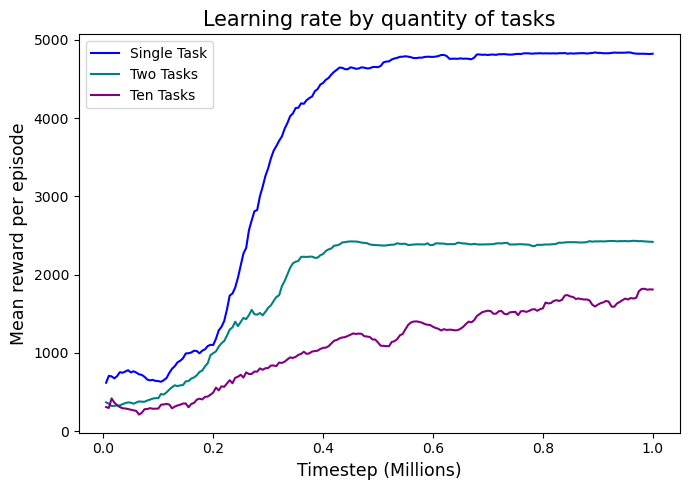

In [99]:
plot_stacked(
    [sac_1_data, sac_2_data, sac_3_data],
    ['Single Task', 'Two Tasks', 'Ten Tasks'],
    xlabel='Timestep (Millions)',
    ylabel='Mean reward per episode',
    title='Learning rate by quantity of tasks',
    c=['Blue','Teal','Purple']
    
)